Load All Records

In [6]:
import wfdb
import pandas as pd

record_ids = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109'  # Add more if available
]

all_records = []

for record_id in record_ids:
    try:
        record = wfdb.rdrecord(f"../Data/{record_id}")
        annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')
        all_records.append({
            "record_id": record_id,
            "fs": record.fs,
            "n_samples": record.sig_len,
            "n_channels": record.n_sig,
            "annotations": annotation.sample
        })
        print(f"Loaded {record_id}")
    except Exception as e:
        print(f"Error loading {record_id}: {e}")

# Create summary DataFrame
summary = []

for rec in all_records:
    summary.append({
        "ID": rec["record_id"],
        "Sampling Rate (Hz)": rec["fs"],
        "Total Samples": rec["n_samples"],
        "Channels": rec["n_channels"],
        "Beats Detected": len(rec["annotations"])
    })
# Extracted metadata is stored as a DataFrame for better visualization
df_summary = pd.DataFrame(summary)
print(df_summary)


Loaded 100
Loaded 101
Loaded 102
Loaded 103
Loaded 104
Loaded 105
Loaded 106
Loaded 107
Loaded 108
Loaded 109
    ID  Sampling Rate (Hz)  Total Samples  Channels  Beats Detected
0  100                 360         650000         2            2274
1  101                 360         650000         2            1874
2  102                 360         650000         2            2192
3  103                 360         650000         2            2091
4  104                 360         650000         2            2311
5  105                 360         650000         2            2691
6  106                 360         650000         2            2098
7  107                 360         650000         2            2140
8  108                 360         650000         2            1824
9  109                 360         650000         2            2535


In [12]:
import wfdb
import wfdb

record = wfdb.rdrecord("../Data/100")   # no .dat
ann = wfdb.rdann("../Data/100", "atr")

print("p_signal shape:", record.p_signal.shape)
print("fs:", record.fs)
print("ann samples:", len(ann.sample))
print("example symbols:", sorted(set(ann.symbol))[:20])


p_signal shape: (650000, 2)
fs: 360
ann samples: 2274
example symbols: ['+', 'A', 'N', 'V']


##### Result is gonna look like this 
__p_signal shape__: (650000, 2)    
__fs__: 360     
__ann samples__: 2274   
__example symbols__: ['+', 'A', 'N', 'V']   

1. Number of samples taken and number of channels
2. These many samples taken in one second - for each patients 30 minutes long ECG 
3. These many points where beats occured  
4. For each heart beat what kind of beat it is 
- 'N' → Normal beat
- 'A' → Atrial premature beat(APB)
- 'V' → Ventricular ectopic beat
- '+' → Segment marker

Code to visualize one beat of each type

In [17]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load the record (replace with your file path or record name)
record = wfdb.rdrecord('100', pn_dir='mitdb')  # if local: give path
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')

p_signal = record.p_signal
fs = record.fs
ann_samples = annotation.sample
ann_symbols = annotation.symbol

# Find window with N, A, V, +
target_types = {'N', 'A', 'V', '+'}
window_size = int(fs * 10)  # 10-second window

start_index = None

for i in range(len(ann_samples)):
    start = ann_samples[i]
    end = start + window_size
    # Get all symbols in this window
    symbols_in_window = {ann_symbols[j] for j in range(len(ann_samples))
                         if start <= ann_samples[j] <= end}
    if target_types.issubset(symbols_in_window):
        start_index = start
        break

if start_index is None:
    print("No single window found with all types.")
else:
    end_index = start_index + window_size

    # Plot ECG segment
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(start_index, end_index) / fs, p_signal[start_index:end_index, 0], color='black')
    plt.title("ECG Segment with N, A, V, + Beats")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")

    # Mark beats
    for s, sym in zip(ann_samples, ann_symbols):
        if start_index <= s <= end_index and sym in target_types:
            plt.axvline(s / fs, color='red', linestyle='--', alpha=0.6)
            plt.text(s / fs, max(p_signal[start_index:end_index, 0]),
                     sym, color='blue', fontsize=12, ha='center')

    plt.show()


No single window found with all types.


Code to Extract All Header Features

In [10]:
import wfdb

# Load the header only (no signal data)
record_id = "../Data/100"  # Change to your file
header = wfdb.rdheader(record_id)

# Convert header object to dictionary
header_info = header.__dict__

# Print all features and their values
print("=== Header Metadata ===")
for key, value in header_info.items():
    print(f"{key}: {value}")


=== Header Metadata ===
record_name: 100
n_sig: 2
fs: 360
counter_freq: None
base_counter: None
sig_len: 650000
base_time: None
base_date: None
comments: []
sig_name: ['MLII', 'V5']
p_signal: None
d_signal: None
e_p_signal: None
e_d_signal: None
file_name: ['100.dat', '100.dat']
fmt: ['212', '212']
samps_per_frame: [1, 1]
skew: [None, None]
byte_offset: [None, None]
adc_gain: [986.3720073664825, 1109.127789046653]
baseline: [631, 687]
units: ['mV', 'mV']
adc_res: [12, 12]
adc_zero: [0, 0]
init_value: [488, 615]
checksum: [49741, 25326]
block_size: [0, 0]


Visualize ECG Sample

For Ventricular ectopic beat

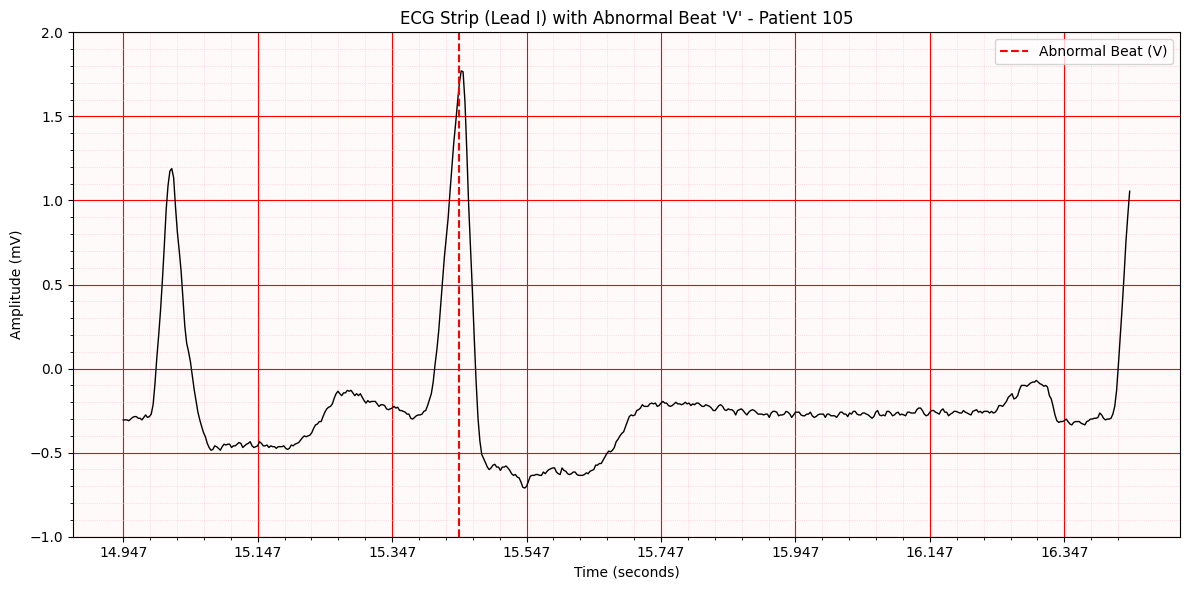

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with abnormal beats
record_id = "105"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'V' beat
Normal_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'V']

if Normal_indices:
    idx = Normal_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Abnormal Beat (V)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Abnormal Beat 'V' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'V' found in patient {record_id}.")


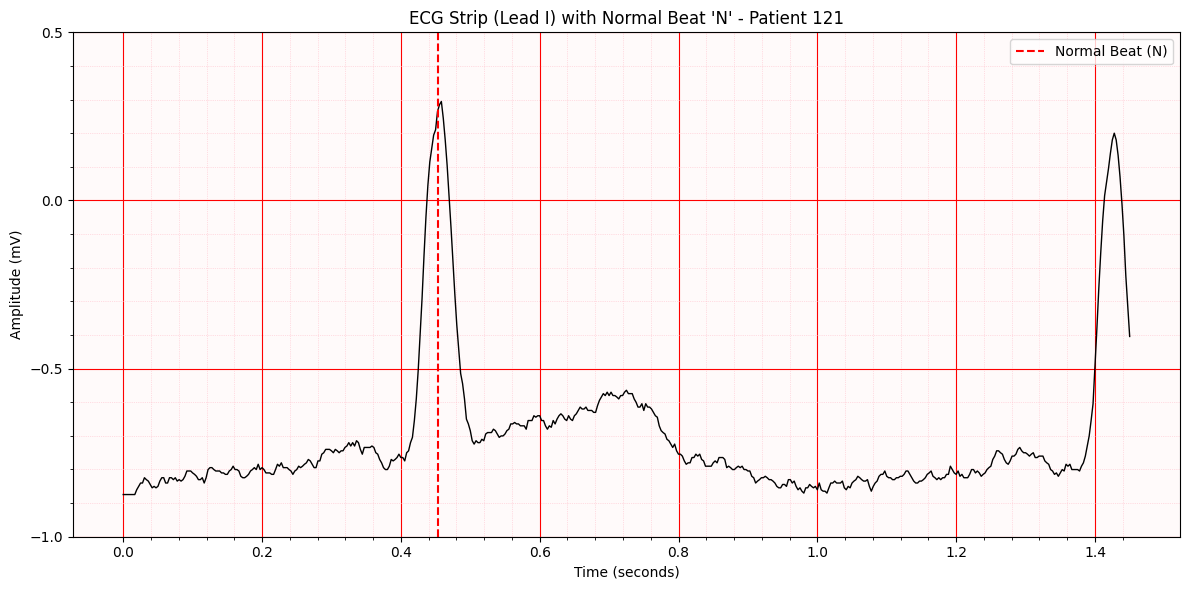

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with Normal beats
record_id = "121"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'N' beat
Normal_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'N']

if Normal_indices:
    idx = Normal_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Normal Beat (N)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Normal Beat 'N' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'N' found in patient {record_id}.")


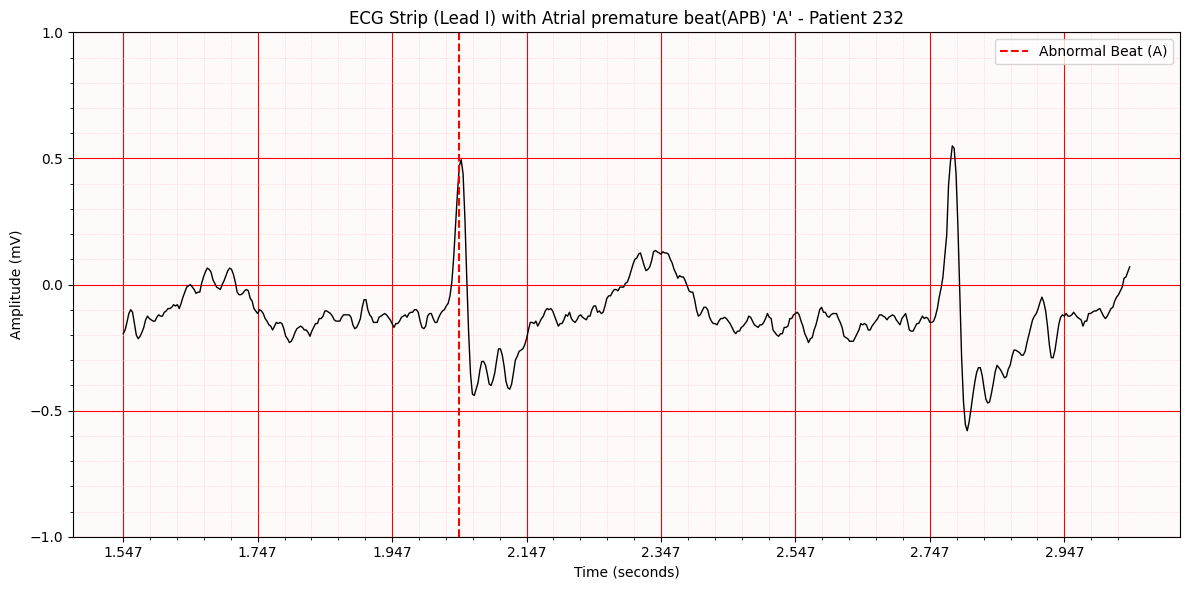

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with abnormal beats
record_id = "232"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'A' beat
Normal_indices = [i for i, sym in enumerate(annotation.symbol) if sym == 'A']

if Normal_indices:
    idx = Normal_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Abnormal Beat (A)")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Atrial premature beat(APB) 'A' - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'A' found in patient {record_id}.")


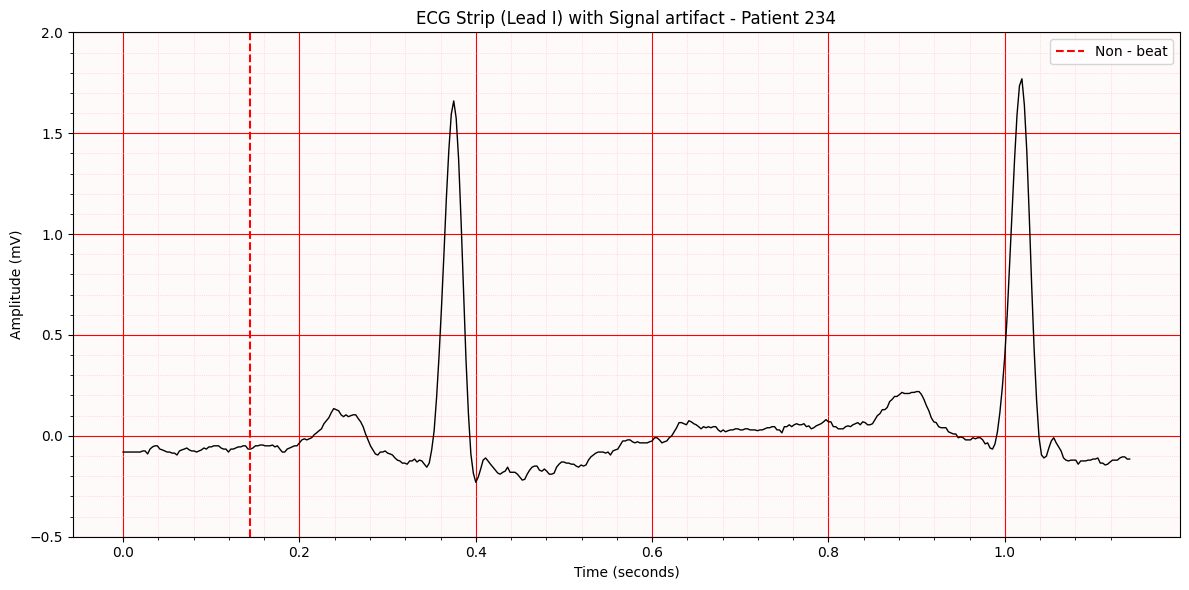

In [36]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Load record with abnormal beats
record_id = "234"
record = wfdb.rdrecord(f"../Data/{record_id}")
annotation = wfdb.rdann(f"../Data/{record_id}", 'atr')

signal = record.p_signal
fs = record.fs  # 360 Hz for MIT-BIH

# Find first 'N' beat
Normal_indices = [i for i, sym in enumerate(annotation.symbol) if sym == '+']

if Normal_indices:
    idx = Normal_indices[0]
    beat_sample = annotation.sample[idx]

    # Window: 0.5s before, 1s after
    start = max(0, beat_sample - int(0.5 * fs))
    end = min(len(signal), beat_sample + int(1.0 * fs))

    ecg_segment = signal[start:end, 0]  # Lead I
    time = np.arange(start, end) / fs

    # Plot ECG segment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time, ecg_segment, color='black', linewidth=1)

    # Mark abnormal beat
    ax.axvline(x=beat_sample / fs, color='red', linestyle='--', label="Non - beat")

    # ECG-style grid setup
    ax.set_facecolor('#fffafa')  # Light pink background

    # Y-axis limits aligned to 0.5 mV blocks
    ymin = np.floor(min(ecg_segment) * 2) / 2
    ymax = np.ceil(max(ecg_segment) * 2) / 2
    ax.set_ylim([ymin, ymax])

    # X-axis major/minor ticks (time)
    major_xticks = np.arange(time[0], time[-1], 0.2)   # Large box = 0.2 sec
    minor_xticks = np.arange(time[0], time[-1], 0.04)  # Small box = 0.04 sec
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)

    # Y-axis major/minor ticks (mV)
    major_yticks = np.arange(ymin, ymax + 0.5, 0.5)
    minor_yticks = np.arange(ymin, ymax + 0.1, 0.1)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # Draw grids
    ax.grid(which='major', color='red', linewidth=0.8)
    ax.grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

    # Labels
    ax.set_title(f"ECG Strip (Lead I) with Signal artifact - Patient {record_id}")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"No abnormal beat 'V' found in patient {record_id}.")


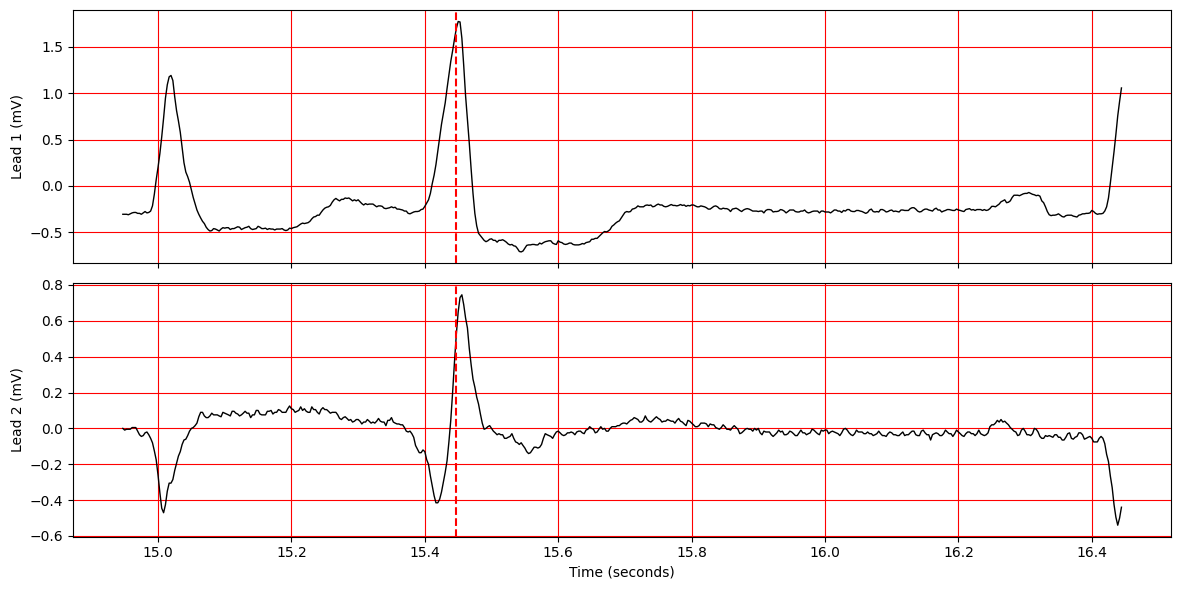

In [9]:
# Full time array for entire recording
time_full = np.arange(record.sig_len) / fs

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for ch in range(record.n_sig):
    axs[ch].plot(time_full[start:end], signal[start:end, ch], color='black', linewidth=1)
    axs[ch].axvline(x=beat_sample / fs, color='red', linestyle='--')
    axs[ch].set_ylabel(f"Lead {ch+1} (mV)")
    axs[ch].grid(which='major', color='red', linewidth=0.8)
    axs[ch].grid(which='minor', color='pink', linestyle=':', linewidth=0.5)

axs[-1].set_xlabel("Time (seconds)")
plt.tight_layout()
plt.show()
